Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* You've worked really hard and submitted a solid project.
* Thank you for structuring the project. It's a pleasure to check such notebooks.
* There are a couple of things that need to be done before your project is complete, but they're pretty straightforward.
* There are few things I'd like you to check. They're not mistakes, but your project could be improved if you correct them.
* While there's room for improvement, on the whole, your project is looking good.
* I believe you can easily fix it! Good luck!

### <font color='orange'>General feedback (review 2)</font>
* Your corrections look great, you've improved your work significantly!
* Your project has been accepted and you can go to the next sprint!
* binary objective is more appropriate in this task. Glad to see that you've used it this time.
* Keep up the good work. Good luck next!

# Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Problem

## I got problems with LightGBM classifier and just work for a few sentences of my reviews

# Init

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [7]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
cat_cols = df_reviews.select_dtypes(include=['object']).columns
num_cols = df_reviews.select_dtypes(exclude=['object']).columns

print(df_reviews[cat_cols].columns)

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'end_year',
       'runtime_minutes', 'genres', 'review', 'sp', 'ds_part'],
      dtype='object')


In [9]:
df_reviews[cat_cols].describe()

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0116191,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


In [10]:
df_reviews[num_cols].describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


<div class="alert alert-block alert-success">
<b>Success:</b> Data loading and initial analysis were done well.
</div>

# EDA

Let's check the number of movies and reviews over years.

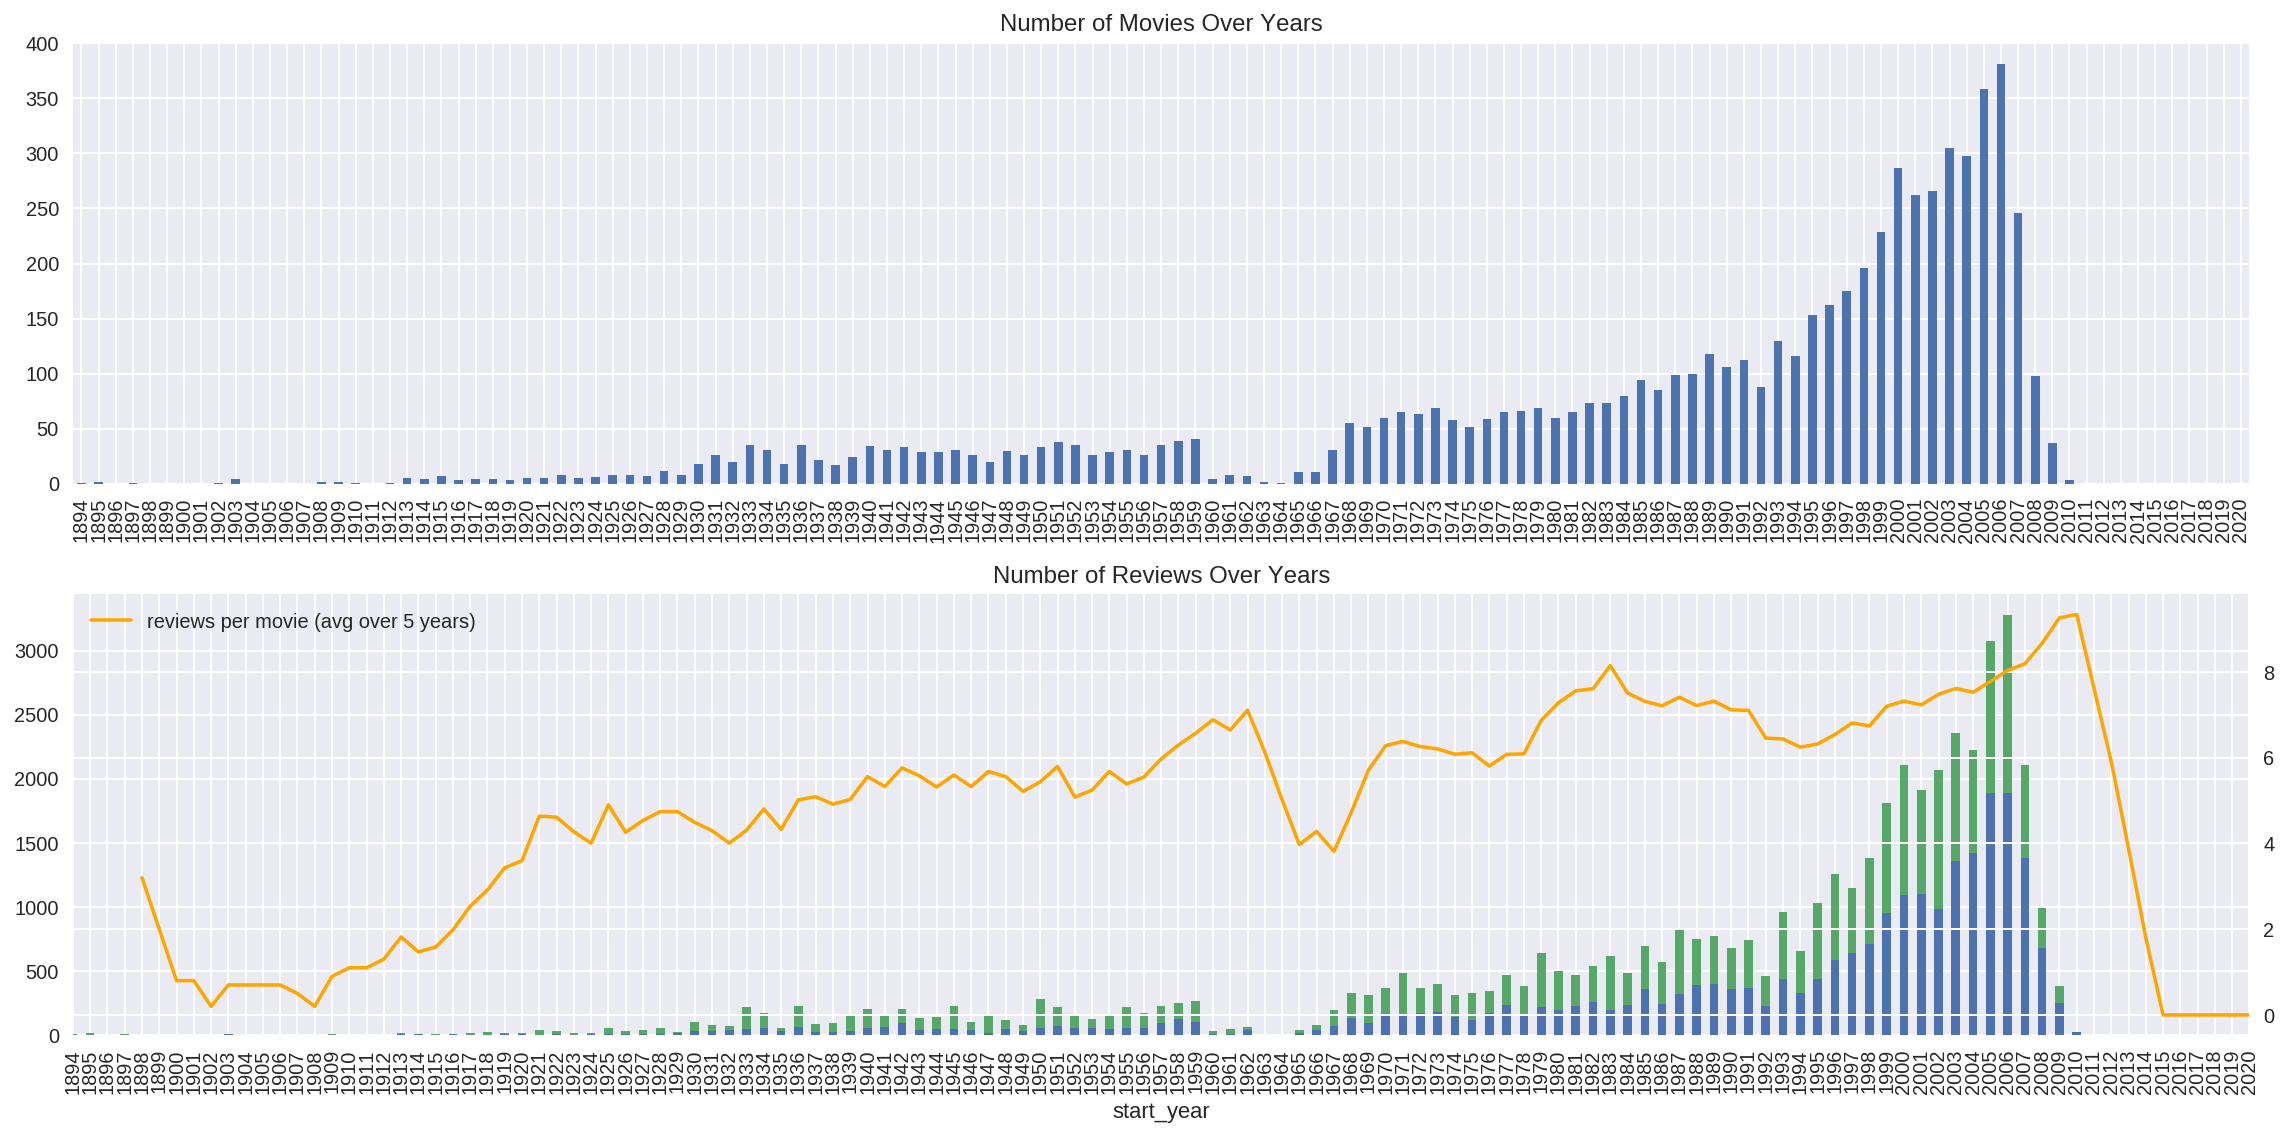

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

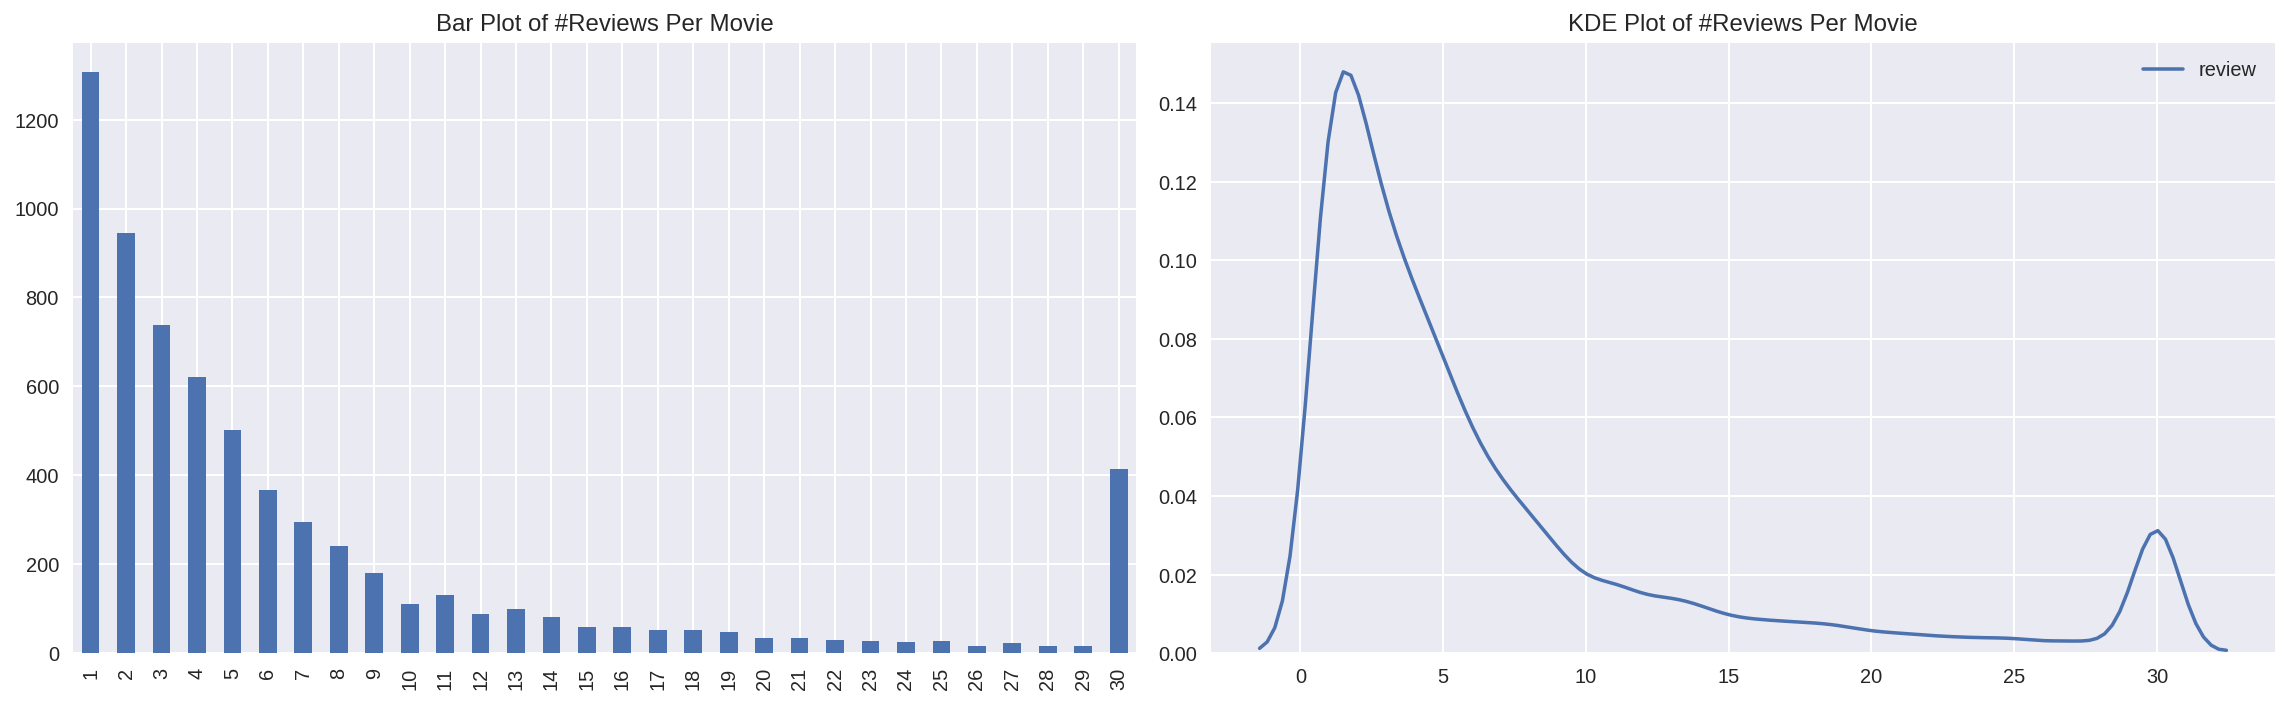

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [13]:
df_reviews[df_reviews['tconst']== dft.index.max()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1555,tt0999866,video,Actium Maximus,Actium Maximus,2005,\N,78,0,Sci-Fi,2.6,160,This was a shockingly bad movie and I literall...,1,neg,0,test,8957
1556,tt0999866,video,Actium Maximus,Actium Maximus,2005,\N,78,0,Sci-Fi,2.6,160,"OK, what to say about Actium Maximus... There ...",1,neg,0,test,8958
1557,tt0999866,video,Actium Maximus,Actium Maximus,2005,\N,78,0,Sci-Fi,2.6,160,I got this movie as a buy one get one deal at ...,1,neg,0,test,8959
1558,tt0999866,video,Actium Maximus,Actium Maximus,2005,\N,78,0,Sci-Fi,2.6,160,"This movie is awful, I'm SORRY. I bought this ...",1,neg,0,test,8960


In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

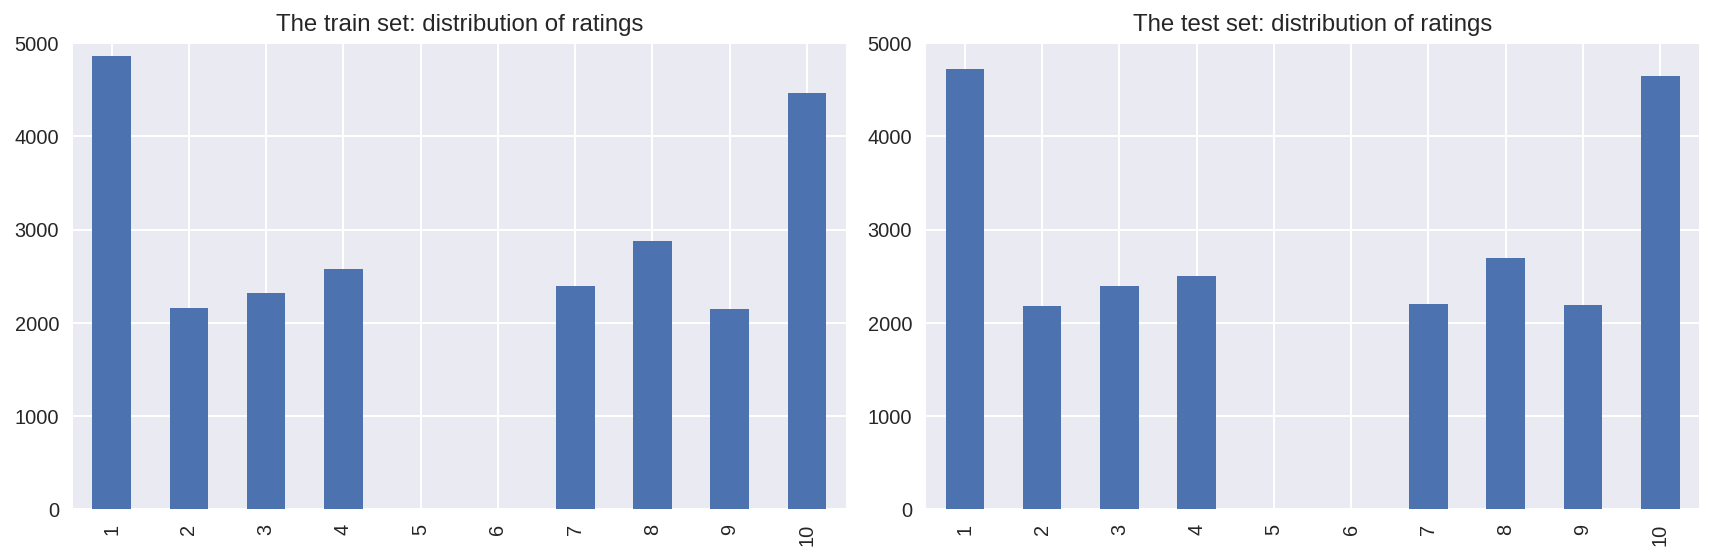

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

It is natural that the more movies are released, the more reviews are made and it seems it has been growing during the pass  of the years. The distribution of the number of reviews per movie has a positive skewed  and a long right tail where there is just one irregular point. Both train and test have similar distributions related to ratings 

Distribution of negative and positive reviews over the years for two parts of the dataset

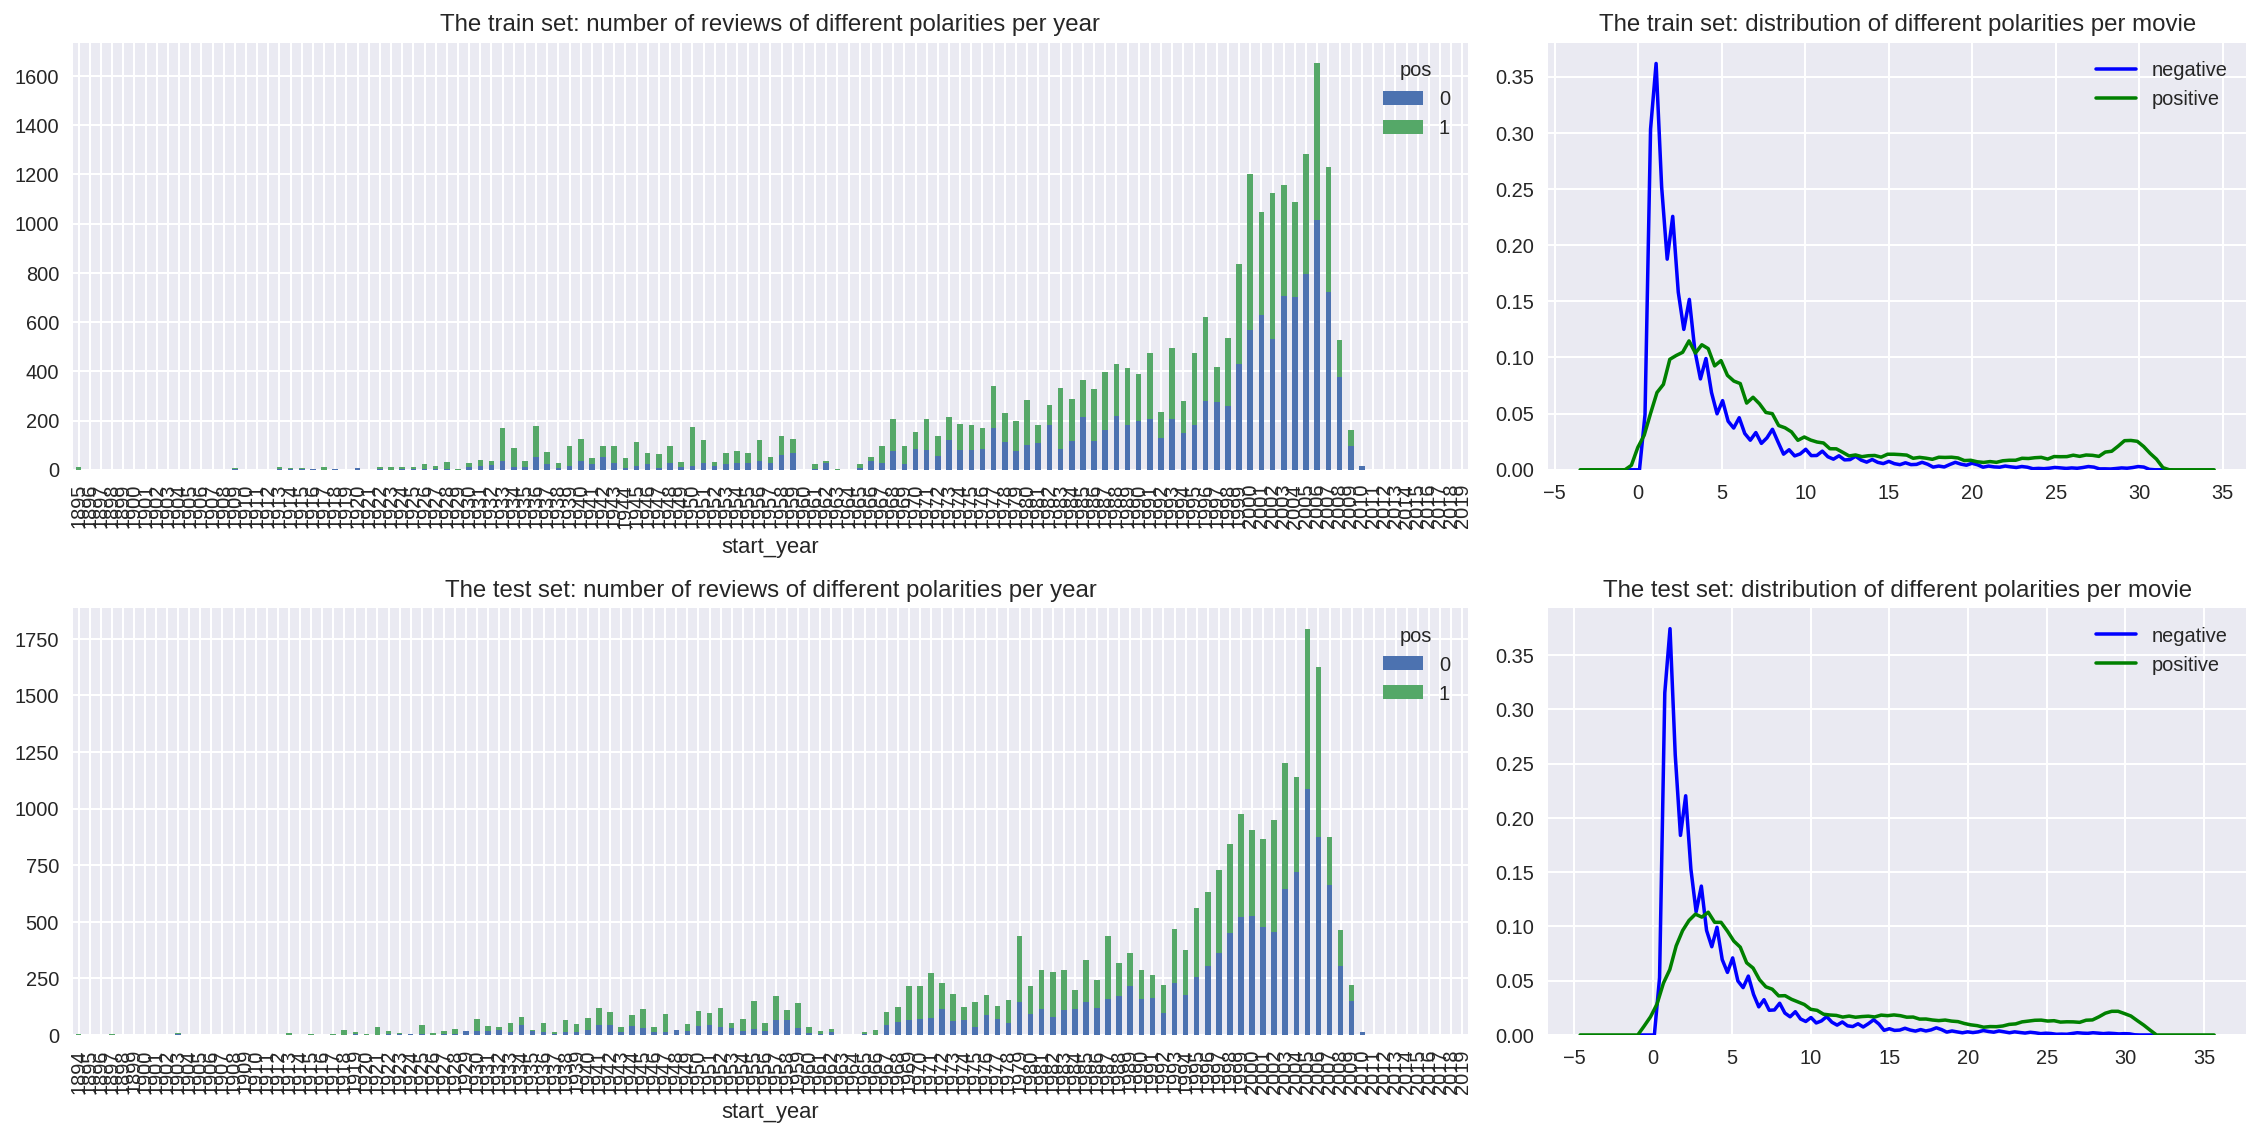

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

In [17]:
train_review = df_reviews.query('ds_part == "train"')
test_review = df_reviews.query('ds_part == "test"')
print('train balance: \n',train_review["pos"].value_counts(normalize = True))
print()
print('test balance: \n',test_review["pos"].value_counts(normalize = True))

train balance: 
 0    0.500588
1    0.499412
Name: pos, dtype: float64

test balance: 
 0    0.501508
1    0.498492
Name: pos, dtype: float64


Talking about the imbalance of the pos variable, postive and negative reviews follow similar distributions, but there is a peak in both cases of tran and test parts where the distance between positive and negative reviews is clearly higher  

<div class="alert alert-block alert-success">
<b>Success:</b> Comments were instresting to read. Great EDA!
</div>

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [20]:
def clean_text(text):
    tokens = word_tokenize(text)
    word_lemma= WordNetLemmatizer()
    lemma=[word_lemma.lemmatize(w, pos = 'n') for w in tokens]
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped]

    return " ".join(words)

In [21]:
df_reviews['review_norm'] = df_reviews["review"].apply(lambda x: clean_text(x))
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um   a serious film about troubled teens in si...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that you've applied lemmatizer correctly.
</div>

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score

In [24]:
def judge_model(model, name, plot=False):
    print(name)
    print('-'*20)
    
    print('Training Performance')
    print('-> Acc:', accuracy_score(train_target, model.predict(df_reviews_train)) )
    print('-> F1:', f1_score(train_target, model.predict(df_reviews_train) ))
    
    print('Testing Performance')
    print('-> Acc:', accuracy_score(test_target, model.predict(df_reviews_test)) )
    print('-> F1:', f1_score(test_target, model.predict(df_reviews_test) ))
    print()

In [25]:
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    model_0 = DummyClassifier(strategy=strategy)
    model_0.fit(df_reviews_train, train_target)
    judge_model(model_0, 'Dummy {}'.format(strategy), plot=False)

Dummy stratified
--------------------
Training Performance
-> Acc: 0.49634392334846195
-> F1: 0.4983722994968926
Testing Performance
-> Acc: 0.497684299978755
-> F1: 0.4911260317324552

Dummy most_frequent
--------------------
Training Performance
-> Acc: 0.5005883341738108
-> F1: 0.0
Testing Performance
-> Acc: 0.5015083917569577
-> F1: 0.0

Dummy prior
--------------------
Training Performance
-> Acc: 0.5005883341738108
-> F1: 0.0
Testing Performance
-> Acc: 0.5015083917569577
-> F1: 0.0

Dummy uniform
--------------------
Training Performance
-> Acc: 0.5028996469994957
-> F1: 0.5051949690825727
Testing Performance
-> Acc: 0.4984491183343956
-> F1: 0.498724706682537



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Following the f2 scoring as our metric, The best Dummies model which trains better is the Training Perfomance

<div class="alert alert-block alert-success">
<b>Success:</b> Good job!
</div>

# Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [26]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [27]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words='english')
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

<div class="alert alert-block alert-success">
<b>Success:</b> Great that vectorizer was fitted only on the train part. It helps to reduce overfitting.
</div>

In [28]:
model_1= LogisticRegression(penalty='l2', max_iter=100, C=1).fit(train_features_1, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


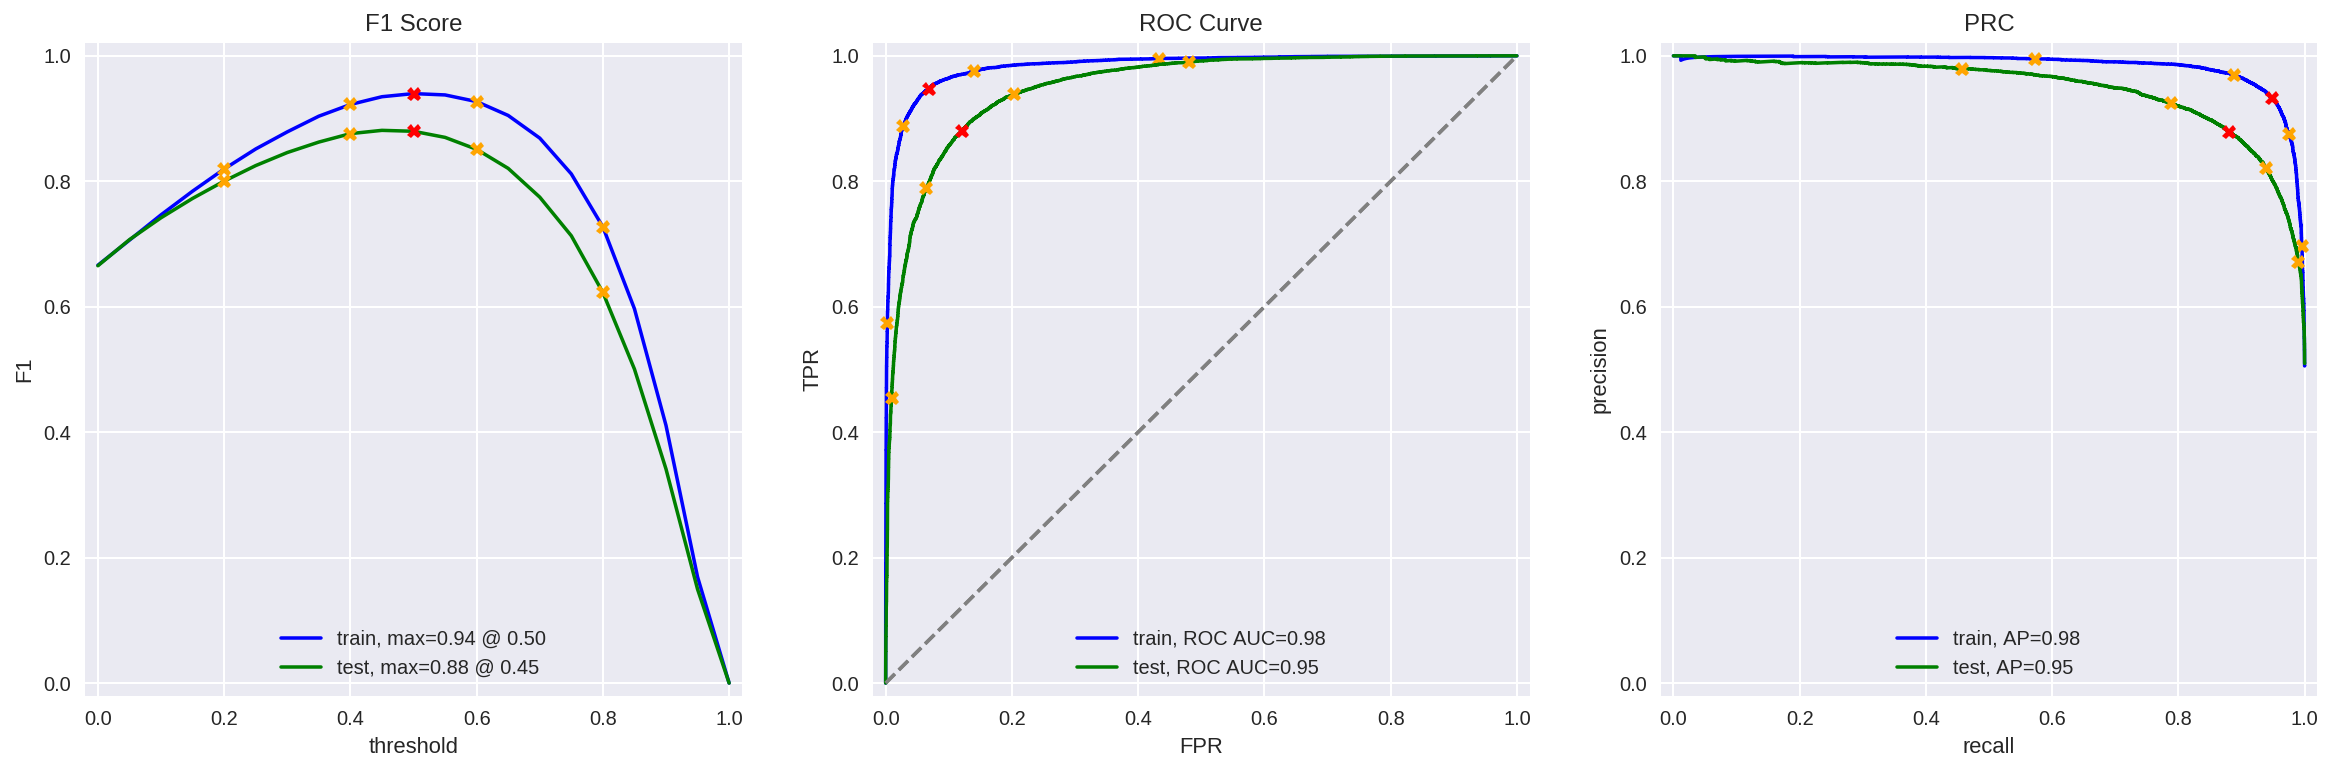

In [29]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The results show that we got good metric values as the f1 score demostrate. The evaluation indicates that there is a good relation  between sensivity and specifity where the model is situated as a really good classificator

# Model 3 - spaCy, TF-IDF and LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer(tokenizer = text_preprocessing_3)
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm'])

In [33]:
model_3= LogisticRegression(penalty='l2', max_iter=100, C=1).fit(train_features_3, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.64  0.63
F1         0.64  0.63
APS        0.68  0.67
ROC AUC    0.69  0.68


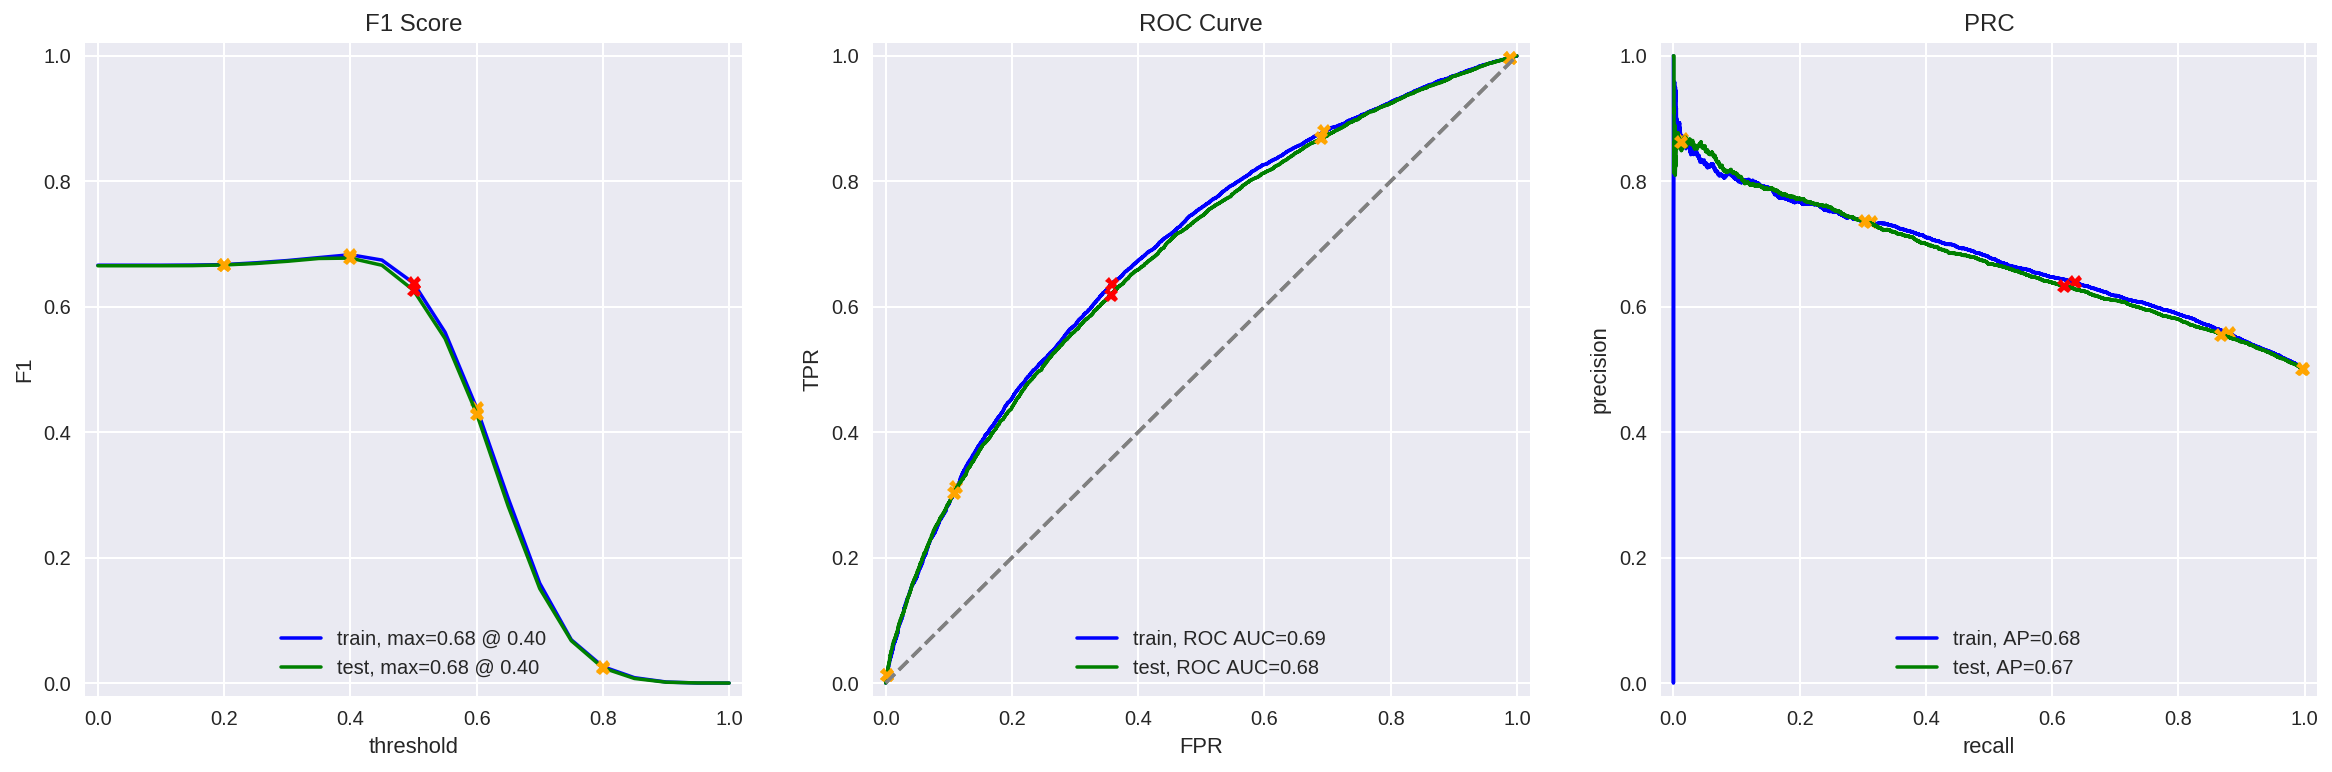

In [37]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Now, it is not good as the results obtained before, cause now we don't get higher metriv values and the model is not classifiying not good enough. 

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Sorry but I don't see metrics here. Please don't forget to apply "evaluate_model" function.
</div>

# Model 4 - spaCy, TF-IDF and LGBMClassifier

In [34]:
import lightgbm as lgbm

In [35]:
tfidf_vectorizer_4 = TfidfVectorizer(tokenizer = text_preprocessing_3)
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_norm'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_norm'])

In [39]:
model_4 = lgbm.LGBMClassifier(objective='binary', num_class=1,verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000)
model_4.fit(train_features_4, train_target)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_bin=2000,
               max_depth=20, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=120, n_jobs=-1, num_class=1,
               num_leaves=50, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.99  0.61
F1         0.99  0.60
APS        1.00  0.64
ROC AUC    1.00  0.65


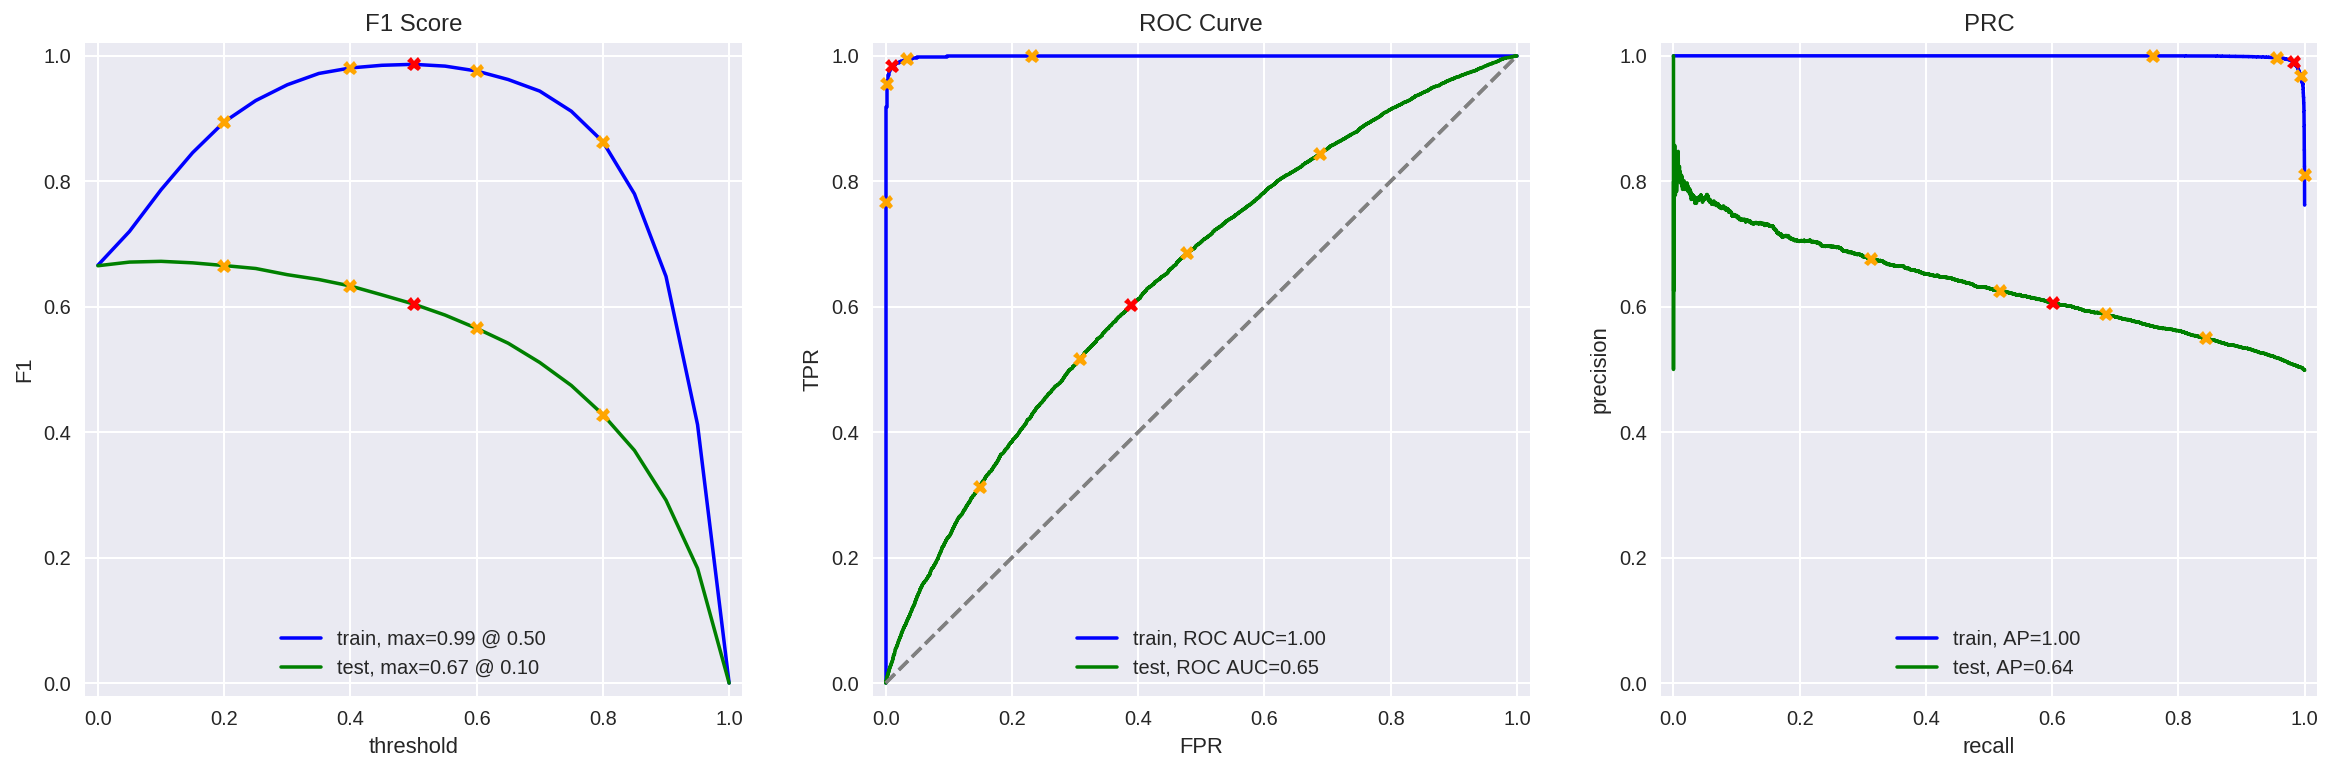

In [40]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

Here, we see that clearly the problem here is teh overfitting, just look how the model trains and it is not good at all

<div class="alert alert-block alert-info">
<b>Improve: </b> Please explain, what for you're passing objective='multiclass' here?
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> There is no "evaluate_model" function here too.
</div>

# My Reviews

In [41]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews["review"].apply(lambda x: clean_text(x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i did nt expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


## Model 1

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_0.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it  not my kind of movie 
0.50:  well  i was bored and felt asleep in the middle of the movie 
0.50:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.50:  i did nt expect the reboot to be so good  writers really cared about the source material
0.50:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.50:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.50:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Model 3

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.29:  i did not simply like it  not my kind of movie 
0.69:  well  i was bored and felt asleep in the middle of the movie 
0.91:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.24:  i did nt expect the reboot to be so good  writers really cared about the source material
0.52:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.34:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.71:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Model 4

In [44]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.96:  i did not simply like it  not my kind of movie 
0.32:  well  i was bored and felt asleep in the middle of the movie 
0.23:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.05:  i did nt expect the reboot to be so good  writers really cared about the source material
0.55:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.46:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.03:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Model 9

In [743]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.21:  i didn t expect the reboot to be so good  writers really cared about the source material
0.94:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


<div class="alert alert-block alert-success">
<b>Success:</b> This part was done well.
</div>

# Conclusions

As a conclusion, the model that predicts better negative reviews and get better f1 score results is the model number 3. In this case que get more dispersion around all the results obtained and in case of the model 1 is the same results in all the text lines. 

<div class="alert alert-block alert-info">
<b>Improve: </b> It would be better if you've expanded the conclusions.
</div>

# Check List

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions